In [561]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold,GroupKFold,KFold,TimeSeriesSplit,GridSearchCV,train_test_split
from rfpimp import *
from tqdm import tqdm
from sklearn.metrics import f1_score,roc_auc_score,mean_squared_error,accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,StandardScaler
from tqdm import tqdm
from datetime import date
from collections import Counter, defaultdict
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('max.rows',8000)
pd.set_option('max.columns',30)

sns.set(rc={'figure.figsize':(13,10)})

In [562]:
df = pd.read_csv("DDOS_vec.csv")

In [563]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,10.0.1.1-8.8.8.8-50659-53-17,10.0.1.1,50659,8.8.8.8,53,17,11/04/2022 11:47:45 PM,5004,4,0,156,0,39,39,39.0,...,0,0,0,0,3,47,0,0,0,0,0,0,0,0,Benign
1,10.0.1.1-8.8.8.8-43247-53-17,10.0.1.1,43247,8.8.8.8,53,17,11/04/2022 11:25:48 PM,5004,4,0,156,0,39,39,39.0,...,0,0,0,0,3,47,0,0,0,0,0,0,0,0,Benign
2,10.0.1.1-10.0.1.2-43048-55555-6,10.0.1.1,43048,10.0.1.2,55555,6,11/04/2022 11:26:09 PM,1,2,1,889,13,881,8,444.5,...,0,0,502,509,1,32,0,0,0,0,0,0,0,0,Benign
3,10.0.1.1-8.8.8.8-60936-53-17,10.0.1.1,60936,8.8.8.8,53,17,11/04/2022 11:25:28 PM,5004,4,0,156,0,39,39,39.0,...,0,0,0,0,3,47,0,0,0,0,0,0,0,0,Benign
4,10.0.1.1-10.0.1.2-43016-55555-6,10.0.1.1,43016,10.0.1.2,55555,6,11/04/2022 11:23:28 PM,1,2,1,841,13,833,8,420.5,...,0,0,502,509,1,32,0,0,0,0,0,0,0,0,Benign


In [564]:
temp = pd.DataFrame(df.nunique()).reset_index()
cols = temp[temp[0] != 1]['index'].to_list()
df_final = df[cols].copy()

In [565]:
def corrleation(dataset,threshold):
    cols_rem = []
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if (corr_matrix.iloc[i,j]>=threshold) and (corr_matrix.columns[j] not in col_corr):
                print(corr_matrix.columns[i],corr_matrix.columns[j])
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(colname)
                    cols_rem.append(colname)
    return cols_rem

In [566]:
# to_drop = ['Flow ID','Src IP','Dst IP','Timestamp']
# feats_corr = ['FWD Init Win Bytes',
#            'Total Length of Fwd Packet','Fwd Packet Length Max','Fwd Packet Length Min',
#           'Fwd Packet Length Mean','Packet Length Min','Packet Length Max','Packet Length Mean',
#           'Average Packet Size',"Fwd Header Length","Fwd Segment Size Avg","Flow Duration","Dst Port",]
# to_drop = to_drop + feats_corr
# df_final.drop(to_drop,inplace=True,axis=1)

Label      
                                                              sum count
SYN Flag Count                                                         
0               BenignBenignBenignBenignBenignBenignBenignBeni...   283
2               MaliciousMaliciousMaliciousMaliciousMaliciousM...   156

In [568]:
label_dic = {
    "Malicious":1,
    "Benign":0
}
df_final['Label'] = df_final['Label'].map(label_dic)

In [569]:
df_final.groupby(['SYN Flag Count']).agg({'Label':['sum','count']})

Label      
                 sum count
SYN Flag Count            
0                144   283
2                156   156

In [500]:
cols_corr = corrleation(df_final.drop('Label',axis=1),0.9)

Total Fwd Packet Protocol
Total Fwd Packet
Total Length of Bwd Packet Total Bwd packets
Total Length of Bwd Packet
Fwd Packet Length Std Total Bwd packets
Fwd Packet Length Std
Bwd Packet Length Max Total Bwd packets
Bwd Packet Length Max
Bwd Packet Length Min Total Bwd packets
Bwd Packet Length Min
Bwd Packet Length Mean Total Bwd packets
Bwd Packet Length Mean
Flow Bytes/s Total Bwd packets
Flow Bytes/s
Flow Packets/s Total Bwd packets
Flow Packets/s
Flow IAT Std Protocol
Flow IAT Std
Fwd IAT Total Flow IAT Max
Fwd IAT Total
Fwd IAT Mean Flow IAT Mean
Fwd IAT Mean
Fwd IAT Std Protocol
Fwd IAT Std
Fwd IAT Max Flow IAT Max
Fwd IAT Max
Fwd IAT Min Flow IAT Min
Fwd IAT Min
Fwd PSH Flags Total Bwd packets
Fwd PSH Flags
Bwd Header Length Total Bwd packets
Bwd Header Length
Bwd Packets/s Fwd Packets/s
Bwd Packets/s
Packet Length Std Total Bwd packets
Packet Length Std
Packet Length Variance Total Bwd packets
Packet Length Variance
PSH Flag Count Total Bwd packets
PSH Flag Count
Bwd Segment 

In [501]:
df_final.drop(cols_corr,axis=1,inplace=True)

In [502]:
df_final.head()

,Src Port,Protocol,Total Bwd packets,Flow IAT Mean,Flow IAT Max,Flow IAT Min,Fwd Packets/s,ACK Flag Count,Bwd Bytes/Bulk Avg,Label
0,50659,17,0,1668.0,5004,0,7.993605e+02,0,156,0
1,43247,17,0,1668.0,5004,0,7.993605e+02,0,156,0
2,43048,6,1,0.5,1,0,2.000000e+06,3,0,0
3,60936,17,0,1668.0,5004,0,7.993605e+02,0,156,0
4,43016,6,1,0.5,1,0,2.000000e+06,3,0,0


In [503]:
cols_rem = corrleation(df_final,0.1)

Protocol Src Port
Protocol
Flow IAT Max Src Port
Flow IAT Max
Flow IAT Max Flow IAT Mean
Flow IAT Max
Flow IAT Min Flow IAT Mean
Flow IAT Min
Fwd Packets/s Total Bwd packets
Fwd Packets/s
ACK Flag Count Total Bwd packets
ACK Flag Count
Bwd Bytes/Bulk Avg Src Port
Bwd Bytes/Bulk Avg


In [504]:
df_final['Label'].value_counts(normalize=True)

1    0.683371
0    0.316629
Name: Label, dtype: float64

In [505]:
float64_cols = list(df_final.select_dtypes(include='float64'))
int64_cols = list(df_final.select_dtypes(include='int64'))


df_final[float64_cols] = df_final[float64_cols].astype("float32")
df_final[int64_cols] = df_final[int64_cols].astype("int32")

In [506]:
df_final.isnull().sum()

Src Port              0
Protocol              0
Total Bwd packets     0
Flow IAT Mean         0
Flow IAT Max          0
Flow IAT Min          0
Fwd Packets/s         0
ACK Flag Count        0
Bwd Bytes/Bulk Avg    0
Label                 0
dtype: int64

In [507]:
df_final.shape

(439, 10)

In [508]:
df_final.isin([np.inf, -np.inf]).sum()

Src Port              0
Protocol              0
Total Bwd packets     0
Flow IAT Mean         0
Flow IAT Max          0
Flow IAT Min          0
Fwd Packets/s         0
ACK Flag Count        0
Bwd Bytes/Bulk Avg    0
Label                 0
dtype: int64

Basic analysis of the data, we can see how the variables work with the target we need to predict, the more the class separation the better that variable is to predict the finalm output.

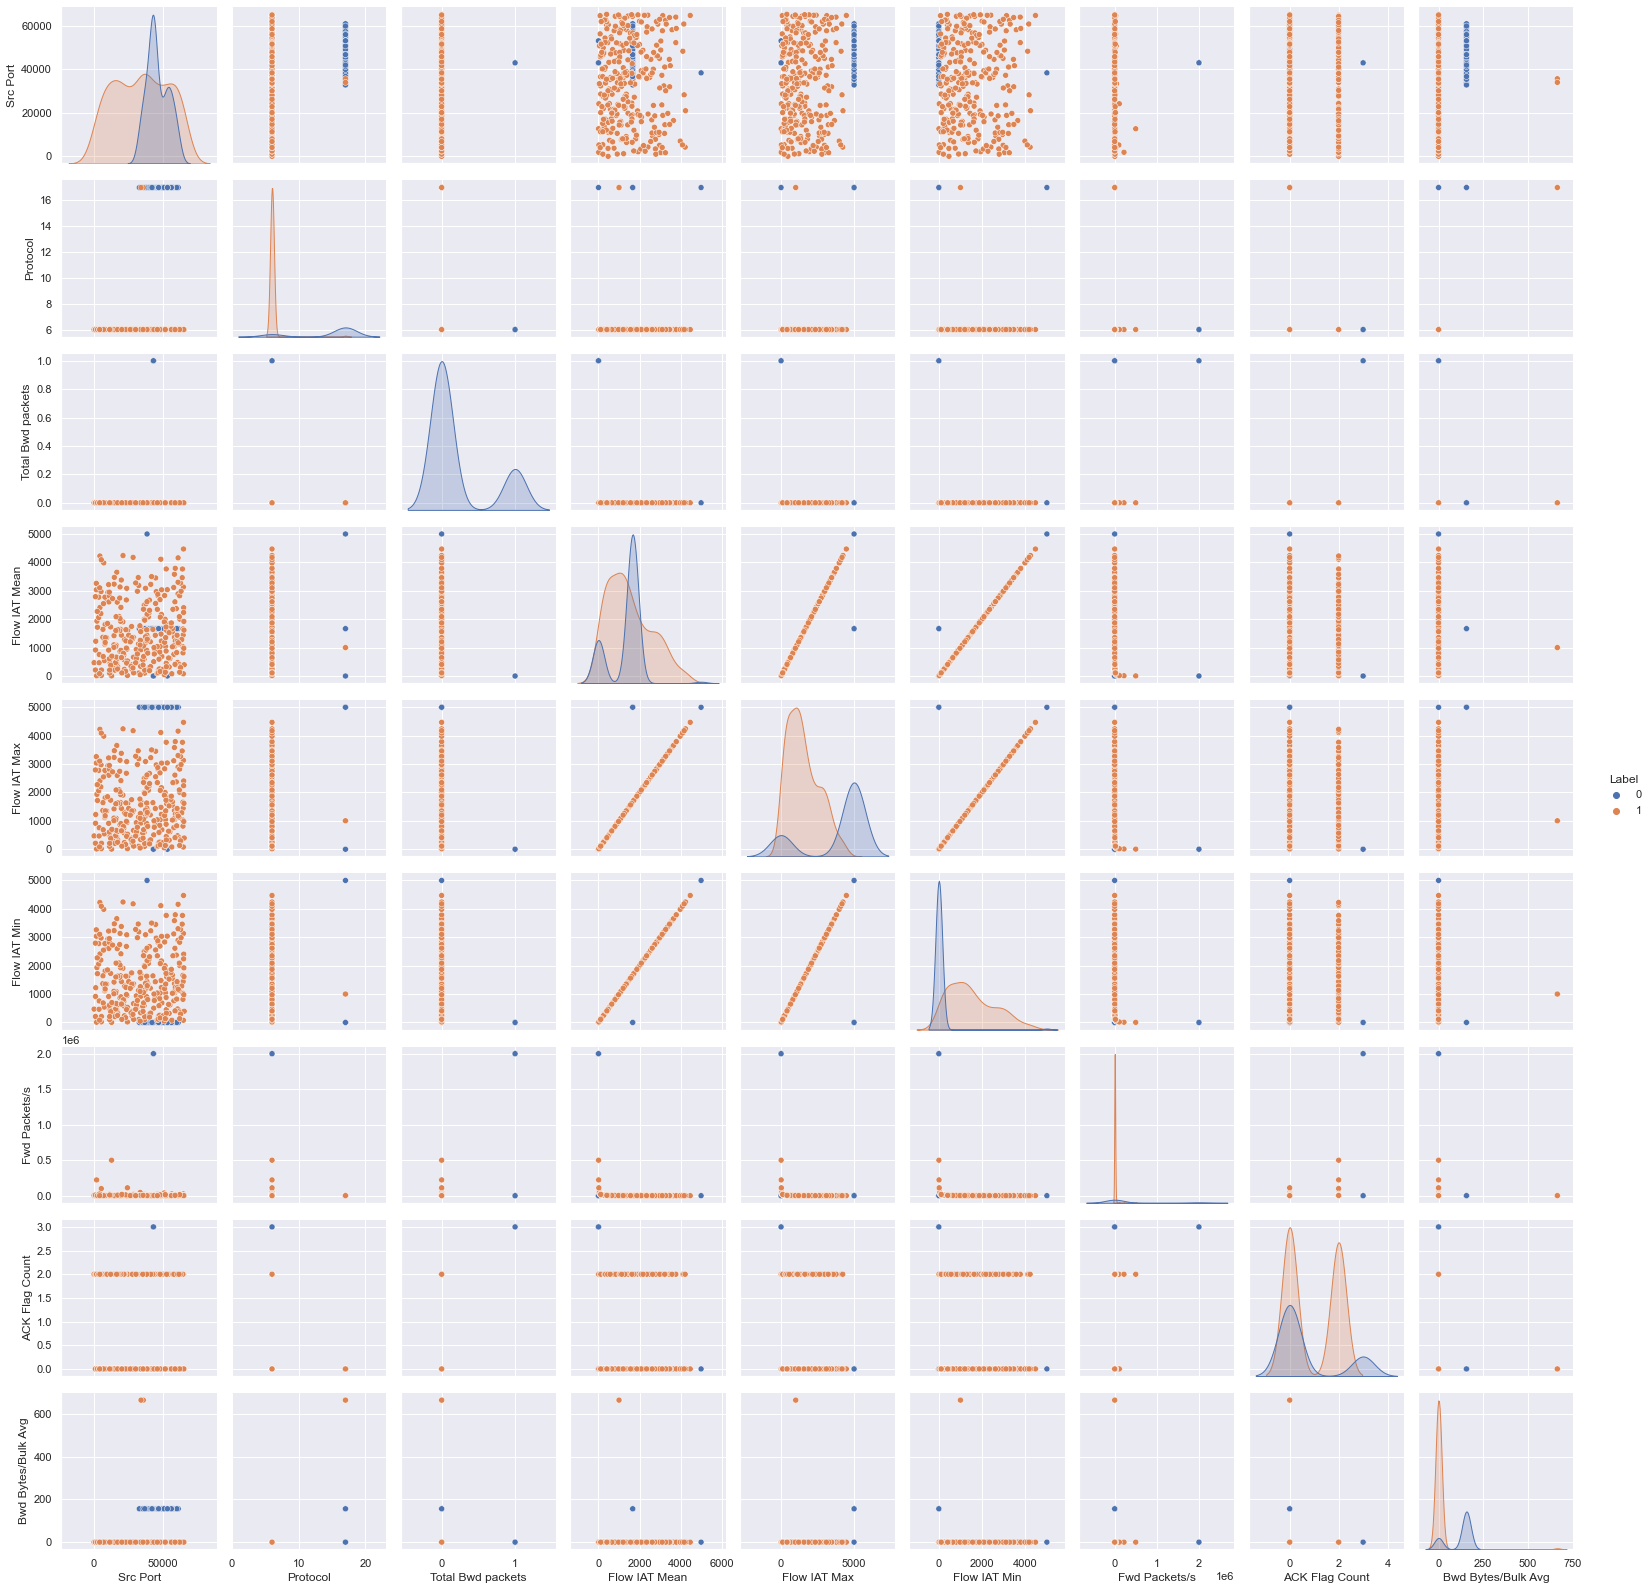

In [509]:
sns.pairplot(df_final, hue="Label")

Avg Packet Size ,Fwd Header Length ,Fwd Segment Size Avg,Flow Duration,Dst Port
can directly tell if a ddos is happening or not

In [537]:
X_train,X_valid,y_train,y_valid = train_test_split(df_final.drop('Label',axis=1),df_final['Label'],stratify=df_final['Label'],random_state=22,test_size=0.3,shuffle=True)

In [549]:
to_drop = ["Fwd Packets/s",'Src Port','Flow IAT Min','Flow IAT Max','Flow IAT Mean','is_valid']

In [539]:
X_train['is_valid'] = 0
X_valid['is_valid'] = 1
temp_df = X_train.append(X_valid)
X_t_tr,X_t_val,y_t_tr,y_t_val = train_test_split(temp_df.drop('is_valid',axis=1),temp_df['is_valid'],stratify=temp_df['is_valid'],random_state=22,test_size=0.2)



In [540]:
clf =RandomForestClassifier()
clf.fit(X_t_tr.drop(to_drop,axis=1),y_t_tr)
roc_auc_score(y_score=clf.predict_proba(X_t_val.drop(to_drop,axis=1))[:,0],y_true=y_t_val)

0.5162706611570248

In [541]:
imp = importances(clf,X_t_val.drop(to_drop,axis=1),y_t_val)
imp

,Importance
Feature,
Bwd Bytes/Bulk Avg,0.011364
Protocol,0.000000
Total Bwd packets,-0.011364
ACK Flag Count,-0.090909


In [542]:
for i in X_train.drop(to_drop,axis=1).columns:
    print(i)
    clf =RandomForestClassifier(random_state=22)
    clf.fit(X_train[i].values.reshape(-1,1),y_train)
    print("Train Accuracy:",accuracy_score(y_pred=clf.predict(X_train[i].values.reshape(-1,1)),y_true=y_train))
    print("Validation Accuracy",accuracy_score(y_pred=clf.predict(X_valid[i].values.reshape(-1,1)),y_true=y_valid))

Protocol
Train Accuracy: 0.9041095890410958
Validation Accuracy 0.95
Total Bwd packets
Train Accuracy: 0.771689497716895
Validation Accuracy 0.7318181818181818
ACK Flag Count
Train Accuracy: 0.771689497716895
Validation Accuracy 0.7318181818181818
Bwd Bytes/Bulk Avg
Train Accuracy: 0.908675799086758
Validation Accuracy 0.9454545454545454
is_valid
Train Accuracy: 0.684931506849315
Validation Accuracy 0.6818181818181818


- Flow IAT Min can predict the output like Flow IAT MAX
- also Total BWD packets only predicts 0 very well

In [543]:
X_train.nunique()

Src Port              219
Protocol                2
Total Bwd packets       2
Flow IAT Mean         149
Flow IAT Max          149
Flow IAT Min          146
Fwd Packets/s         149
ACK Flag Count          3
Bwd Bytes/Bulk Avg      3
is_valid                1
dtype: int64

In [544]:
df_final.groupby("ACK Flag Count").agg({'Label':['sum','count']})

Label      
                 sum count
ACK Flag Count            
0                158   267
2                142   142
3                  0    30

In [545]:
df_final.groupby("Bwd Bytes/Bulk Avg").agg({'Label':['sum','count']})

Label      
                     sum count
Bwd Bytes/Bulk Avg            
0                    298   330
156                    0   107
664                    2     2

In [546]:
df_final.groupby("Protocol").agg({'Label':['sum','count']})

Label      
           sum count
Protocol            
6          298   328
17           2   111

In [547]:
df_final.groupby("Total Bwd packets").agg({'Label':['sum','count']})

Label      
                    sum count
Total Bwd packets            
0                   300   409
1                     0    30

<AxesSubplot:xlabel='Label', ylabel='Flow IAT Mean'>

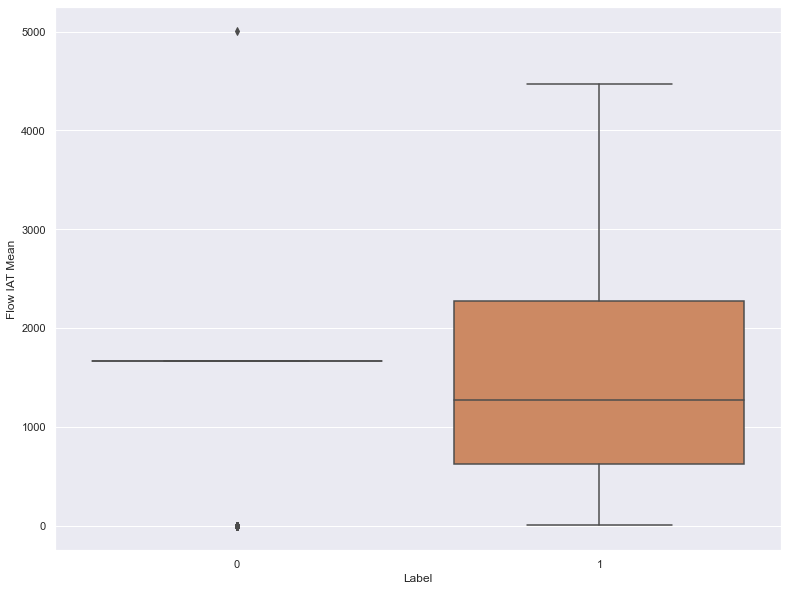

In [548]:
sns.boxplot(y="Flow IAT Mean", x="Label", data=df_final)

In [550]:
clf =RandomForestClassifier(random_state=22)
clf.fit(X_train.drop(to_drop,axis=1),y_train)
print(accuracy_score(y_pred=clf.predict(X_valid.drop(to_drop,axis=1)),y_true=y_valid))

1.0


In [551]:
imp = importances(clf,X_valid.drop(to_drop,axis=1),y_valid)
imp

,Importance
Feature,
Protocol,0.377273
Total Bwd packets,0.081818
ACK Flag Count,0.000000
Bwd Bytes/Bulk Avg,0.000000
